<a href="https://colab.research.google.com/github/JuanSpecht/PDI2021/blob/main/TP3/PDI_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 3: Aritmética de píxeles

### Importo bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from io import BytesIO
import ipywidgets as widgets

### Defino las funciones a utilizar

In [2]:
# Para cargar las imágenes
def image_loader ():
  uploaded = files.upload()
  keys_list = list(uploaded)
  key = keys_list[0]
  img = Image.open(BytesIO(uploaded[key]))
  return img

# Para graficar una imagen en un subplot
def plot_image (axs, position, image, title):
  axs[position].imshow(image)
  axs[position].axis('off')
  axs[position].title.set_text(title)

# Para recortar las imágenes si no coinciden los tamaños
def center_crop(img, crop_width, crop_height):
  img_width, img_height = img.size
  cropped_img = img.crop(((img_width - crop_width) // 2,
                        (img_height - crop_height) // 2,
                        (img_width + crop_width) // 2,
                        (img_height + crop_height) // 2))                  
  return cropped_img
                  
# Para transformar de RGB a YIQ
def rgb_to_yiq (img_rgb):
  # Defino la matriz de transformación RGB -> YIQ
  rgb2yiq = np.array([[0.299, 0.587, 0.114],[0.595716, -0.274453, -0.321263],[0.211456, -0.522591, 0.311135]])
  
  img_rgb_norm = img_rgb/255
  img_yiq = np.einsum('kl,ijl->ijk', rgb2yiq, img_rgb_norm)
  return img_yiq

# Para transformar de YIQ a RGB
def yiq_to_rgb (img_yiq):
  # Defino la matriz de transformación YIQ -> RGB
  yiq2rgb = np.array([[1, 0.9663, 0.6210], [1, -0.2721, -0.6474], [1, -1.1070, 1.7046]])

  # Transformo de YIQ a RGB normalizado
  img_rgb_norm = np.einsum('kl,ijl->ijk', yiq2rgb, img_yiq)

  # Acoto los valores de los canales R, G y B al intervalo [0,1]
  img_rgb_norm = np.clip(img_rgb_norm, 0, 1)

  # Convierto a bytes y redondeo a enteros
  img_rgb = img_rgb_norm * 255 
  img_rgb = np.rint(img_rgb).astype(np.int32)
  return img_rgb

# Para realizar operaciones en RGB
def rgb_operation (op, img_1, img_2):
  if op == 'Clamped addition':
    result = np.add(np.array(img_1), np.array(img_2), dtype=np.int32)
    result = np.clip(result, 0, 255)
  if op == 'Averaged addition':
    result = np.add(np.array(img_1), np.array(img_2), dtype=np.int32) // 2
  if op == 'Clamped subtraction':
    result = np.subtract(np.array(img_1), np.array(img_2), dtype=np.int32) 
    result = np.clip(result, 0, 255)
  if op == 'Averaged subtraction':
    result = (np.subtract(np.array(img_1, dtype=np.int32), np.array(img_2, dtype=np.int32)) + 255) // 2
  return result

# Para realizar operaciones en YIQ
def yiq_operation(op, img_1, img_2):
  # Transformo ambas imágenes a YIQ
  img_1_yiq = rgb_to_yiq (np.array(img_1))
  img_2_yiq = rgb_to_yiq (np.array(img_2))

  # Defino los canales Y, I y Q
  y_1 = img_1_yiq[:,:,0]
  i_1 = img_1_yiq[:,:,1]
  q_1 = img_1_yiq[:,:,2]
  y_2 = img_2_yiq[:,:,0]
  i_2 = img_2_yiq[:,:,1]
  q_2 = img_2_yiq[:,:,2]

  # Realizo la operación según indique el argumento "op"
  if op == 'Clamped addition' or op == 'Averaged addition': # La operación es una cuasi-suma
    i_result = ( y_1/(y_1 + y_2) ) * i_1 + ( y_2/(y_1 + y_2) ) * i_2
    q_result = ( y_1/(y_1 + y_2) ) * q_1 + ( y_2/(y_1 + y_2) ) * q_2
    if op == 'Clamped addition': # Cuasi-suma "clampeada"
      y_result = np.clip(y_1 + y_2, 0, 1)
    if op == 'Averaged addition': # Cuasi-suma promediada
      y_result = (y_1 + y_2) / 2

  if op == 'Clamped subtraction' or op == 'Averaged subtraction': # La operación es una cuasi-resta
    i_result = ( y_1/(y_1 + y_2) ) * i_1 - ( y_2/(y_1 + y_2) ) * i_2
    q_result = ( y_1/(y_1 + y_2) ) * q_1 - ( y_2/(y_1 + y_2) ) * q_2
    if op == 'Clamped subtraction': # Cuasi-resta "clampeada"
      y_result = np.clip(np.subtract(y_1, y_2), 0, 1)
    if op == 'Averaged subtraction': # Cuasi-resta promediada
      y_result = (y_1 - y_2 + np.float64(1)) / 2

  if op == 'If lighter':
    y_result = np.where(y_1 > y_2, y_1, y_2)
    i_result = np.where(y_1 > y_2, i_1, i_2)
    q_result = np.where(y_1 > y_2, q_1, q_2)
  if op == 'If darker':
    y_result = np.where(y_1 < y_2, y_1, y_2)
    i_result = np.where(y_1 < y_2, i_1, i_2)
    q_result = np.where(y_1 < y_2, q_1, q_2)

  # Armo la imagen resultante en YIQ, paso a RGB y acoto a [0, 255]
  result_yiq = np.dstack((y_result, i_result, q_result))
  result = np.clip(yiq_to_rgb (result_yiq), 0, 255)
  return result

# Sumador de imágenes
def result_plotter (mode, operation):
  
  op = {"RGB": rgb_operation,
        "YIQ": yiq_operation}

  # Aplico la operación a las imágenes
  result_plotter.final_img = op[mode](operation, np.array(img_1), np.array(img_2))

  fig, axs = plt.subplots(1,3, figsize= (23,8))
  fig.tight_layout()

  plot_image(axs, 0, np.array(img_1), 'Image 1')
  plot_image(axs, 1, np.array(img_2), 'Image 2')
  plot_image(axs, 2, result_plotter.final_img, mode + ' ' + operation)

# Para guardar la imagen resultante
def save_image (img, operation):
  # Transformo el array de numpy en una imagen de PIL y la guardo
  img_to_save = Image.fromarray(np.uint8(result_plotter.final_img)).convert('RGB')
  output_filename = operation + '.jpg'
  img_to_save.save(output_filename)

  print('La imagen ha sido guardada como ' + '\'' + output_filename + '\'.')

### Se cargan las imágenes, se recortan si es necesario y se realiza la operación seleccionada

In [3]:
# Se cargan las imágenes
img_1 = image_loader()
img_2 = image_loader()

# Si los tamaños no coinciden se recortan al mayor tamaño posible
if img_1.size != img_2.size:
  height_final = min(img_1.size[0], img_2.size[0])
  width_final = min(img_1.size[1], img_2.size[1])

  img_1 = center_crop(img_1, height_final, width_final)
  img_2 = center_crop(img_2, height_final, width_final)

# Se definen la operaciones posibles
operations = {
            'RGB':['Clamped addition', 'Clamped subtraction',
                    'Averaged addition', 'Averaged subtraction'],
            'YIQ':['Clamped addition', 'Clamped subtraction',
                    'Averaged addition', 'Averaged subtraction',
                    'If lighter','If darker']
              }

# Se selecciona el modo (RGB o YIQ) y la operación a realizar, y se grafica
def select_operation(mode):
    operations_widget.options = operations[mode]

modes_widget = widgets.Select(options=operations.keys())
init = modes_widget.value
operations_widget = widgets.Select(options=operations[init])
i = widgets.interactive(select_operation, mode=modes_widget)
j = widgets.interactive(result_plotter, mode=modes_widget, operation=operations_widget)
display(j)

button = widgets.Button(description="Save")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
      save_image(result_plotter.final_img, modes_widget.value + ' ' +operations_widget.value)

button.on_click(on_button_clicked)

Saving imagen_1.jpg to imagen_1.jpg


Saving image_2.jpg to image_2.jpg


interactive(children=(Select(description='mode', options=('RGB', 'YIQ'), value='RGB'), Select(description='ope…

Button(description='Save', style=ButtonStyle())

Output()

### Comparo los resultados de todas las operaciones

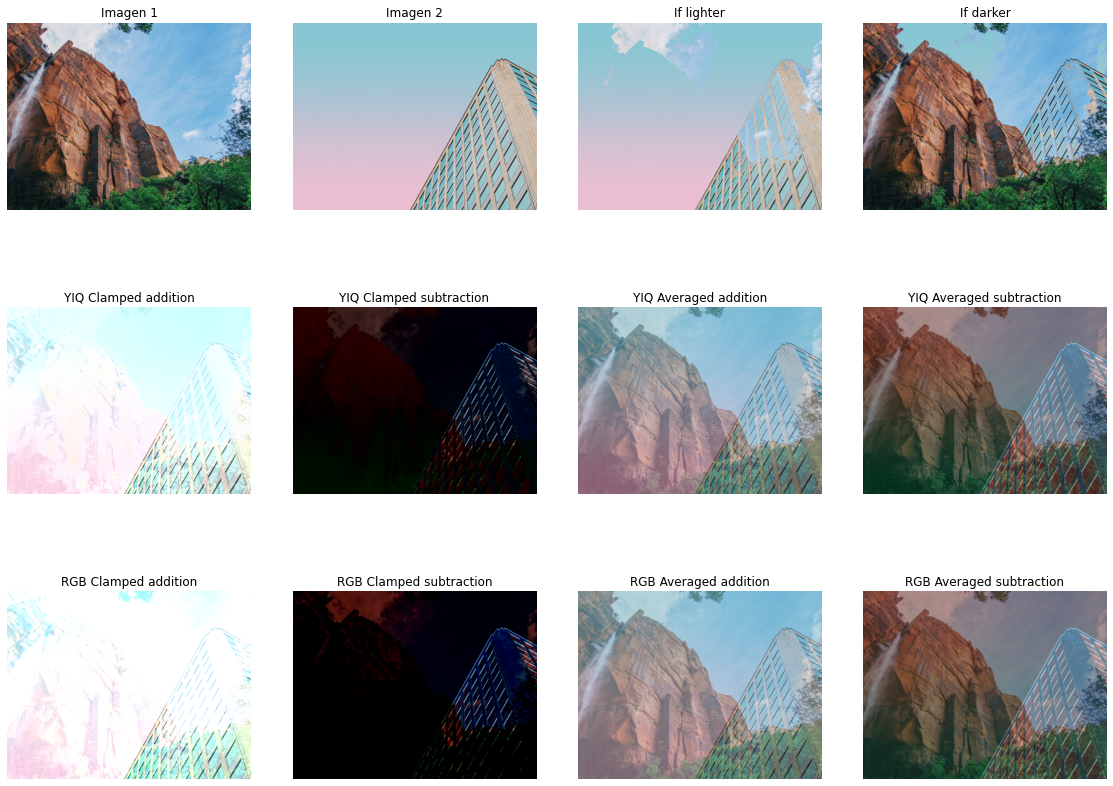

In [4]:
mode = {"YIQ": yiq_operation,
      "RGB": rgb_operation
              }

operations = {
    'YIQ':['Clamped addition', 'Clamped subtraction',
          'Averaged addition', 'Averaged subtraction'],
    'RGB':['Clamped addition', 'Clamped subtraction',
            'Averaged addition', 'Averaged subtraction']
            }

# Grafico las imágenes originales y los resultados de "if ligther" y de "if darker"
img_if_lighter = yiq_operation ('If lighter', np.array(img_1), np.array(img_2))
img_if_darker = yiq_operation ('If darker', np.array(img_1), np.array(img_2))

fig, axs = plt.subplots(3,4, figsize = (16,12))
fig.tight_layout()
plot_image (axs, (0,0), img_1, 'Imagen 1')
plot_image (axs, (0,1), img_2, 'Imagen 2')
plot_image (axs, (0,2), img_if_lighter, 'If lighter')
plot_image (axs, (0,3), img_if_darker, 'If darker')

# Grafico los resultados del resto de las operaciones
for i in range(len(list(mode))):
  for j in range(len(operations[list(operations)[i]])):
    final_img = mode[list(mode)[i]](operations[list(operations)[i]][j],
                        np.array(img_1),
                        np.array(img_2))
    plot_image (axs, (i+1,j), final_img, list(mode)[i] + ' ' + operations[list(operations)[i]][j])

### De la comparación se comprueban las observaciones esperadas:

* Las sumas clampeadas (tanto en RGB como en YIQ) son más luminosas que las imágenes originales.
* La suma clampeada en RGB satura al blanco, ya que los pixeles de la imagen resultante con valores mayores que 255 en sus tres componentes se acotan a 255. Este efecto desaparece en la suma clampeada en YIQ .
* De la misma manera la resta clampeada en RGB satura al negro, ya que los pixeles donde la resta resulta negativa se fuerzan a 0.
* Se puede ver que las sumas promediadas tienen menor luminosidad que las clampeadas, ya que en este caso la luminancia de cada pixel es un promedio de las luminancias de los píxeles correspondientes de las imágenes originales
* La suma promediada genera el mismo resultado al realizarla en RGB y en YIQ. Lo mismo sucede con la resta promediada
